In [1]:
import numpy as np
from src.cost import LogCost
from src.cpop import CPOP
import matplotlib.pyplot as plt

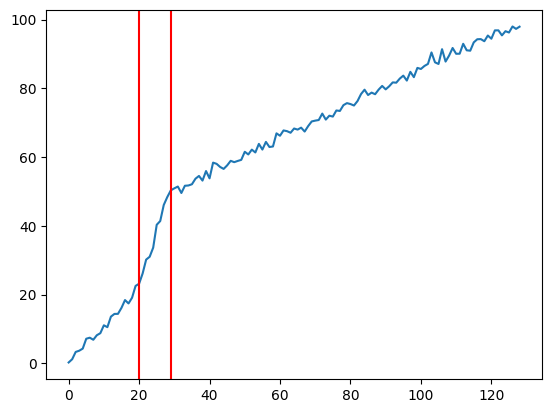

In [ ]:
y = np.concatenate([np.arange(1, 20), np.arange(20, 50, 3), np.arange(50, 100, 0.5)])
y += np.random.randn(len(y))
h = LogCost(1)
sigma = 1
beta = 200

detector = CPOP(y, sigma, beta, h)
output = detector.run()
output = [x-1 for x in output] # On doit supprimer un indice
plt.plot(y)
for idx in output[1:]: # On ne prends pas en compte le premier change points (0 par convention)
    plt.axvline(idx, c="r")

In [5]:
output

[-1, 20, 29]